In [5]:
import os

import numpy as np
import pandas as pd

import zipfile

# Récupération des jeux de données

In [6]:
# Fichier kaggle.json pour charger les jeux de données
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
# CREMA-D
!kaggle datasets download -d 'ejlok1/cremad'
# SAVEE
!kaggle datasets download -d 'ejlok1/surrey-audiovisual-expressed-emotion-savee'
# TESS
!kaggle datasets download -d 'ejlok1/toronto-emotional-speech-set-tess'
# RAVDESS
!kaggle datasets download -d 'uwrfkaggler/ravdess-emotional-speech-audio'

 99% 448M/451M [00:12<00:00, 43.0MB/s]
100% 451M/451M [00:12<00:00, 37.8MB/s]
 99% 106M/107M [00:03<00:00, 42.0MB/s]
100% 107M/107M [00:03<00:00, 33.0MB/s]
100% 428M/428M [00:12<00:00, 36.7MB/s]
100% 428M/428M [00:12<00:00, 37.3MB/s]
 99% 426M/429M [00:12<00:00, 42.3MB/s]
100% 429M/429M [00:12<00:00, 35.1MB/s]


## RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)

Le RAVDESS contient un ensemble de 1440 fichiers audio. Un audio est caractérisé par les informations suivantes :

- L'acteur qui prononce une phrase (au total 24 acteurs dont 12 hommes et 12 femmes)
- Une émotion (neutral, calm, happy, sad, angry, fearful, disgust, surprise)
- Une intensité : expression normale de l'émotion ou accentuée (sauf pour l'émotion neutral)
- Une phrase

Chaque phrase est répétée deux fois.

Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

https://zenodo.org/record/1188976

In [8]:
# Extraction du dossier téléchargé
zip_file_path = 'ravdess-emotional-speech-audio.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('ravdess')

### Informations sur la structure du jeu de données
* Modalité (03 pour l'audio)
* Type de son (01 pour quelqu'un qui parle)
* Émotions (01=neutral, 02=calm, 03=happy, 04=sad, 05=angry, 06=fearful, 07=disgust, 08 = surprised)
* Intensité de l'émotion (01 pour normale, 02 pour forte)
* Phrase (01="Kids are talking by the door", 02="Dogs are sitting by the door")
* Répétition (01, 02)
* Acteur (01 → 24) sachant que les actrices portent un numéro pair et les acteurs un numéro impair

Exemple de fichier : /content/ravdess/Actor_11/03-01-05-01-01-02-11.wav

In [9]:
ravdess_dir = 'ravdess'

ravdess_file_paths = []
ravdess_emotions = []
ravdess_genders = []

ravdess_dic = {
    '01' : 'neutral',
    '02' : 'calm',
    '03' : 'happy',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
    '08' : 'surprise'
}

ravdess_gender = {
    0 : 'female',
    1 : 'male'
}

In [10]:
# Suppression du sous-dossier /content/ravdess/audio_speech_actors_01-24
# Conservation des sous-dossiers /Actor_01, /Actor_02, ..., /Actor_24
!rm -r '/content/ravdess/audio_speech_actors_01-24'

In [11]:
# Extraction : chemin du fichier, émotion, genre
for subdir, _, files in os.walk(ravdess_dir):
    for filename in files:
        if filename.endswith('.wav'):
            # Chemin d'accès vers le fichier
            ravdess_file_paths.append(os.path.join(subdir, filename))

            # Émotion
            emotion = ravdess_dic[filename.split('-')[2]]
            ravdess_emotions.append(emotion)

            # Genre
            actor_number = filename.split('-')[6]
            actor_number = int(actor_number.split('.wav')[0])
            gender = ravdess_gender[actor_number % 2] # pair=femme, impair=homme
            ravdess_genders.append(gender)

In [12]:
ravdess_df = pd.concat([
    pd.DataFrame(ravdess_file_paths, columns=['path']),
    pd.DataFrame(ravdess_emotions, columns=['emotion']),
    pd.DataFrame(ravdess_genders, columns=['gender'])
], axis=1)

In [13]:
ravdess_df.sample(5)

,path,emotion,gender
58,ravdess/Actor_24/03-01-07-01-01-02-24.wav,disgust,female
383,ravdess/Actor_16/03-01-07-02-02-02-16.wav,disgust,female
1145,ravdess/Actor_18/03-01-03-01-01-02-18.wav,happy,female
963,ravdess/Actor_05/03-01-03-02-02-01-05.wav,happy,male
802,ravdess/Actor_13/03-01-03-02-02-02-13.wav,happy,male


## CREMA-D (Crowd Sourced Emotional Multimodal Actors Dataset)
Ensemble de 7 442 audios provenant de 91 acteurs (48 hommes et 43 femmes)
* [Description du jeu de données (Github)](https://github.com/CheyneyComputerScience/CREMA-D#crema-d-crowd-sourced-emotional-multimodal-actors-dataset)
* [Détails sur la nomenclature des fichiers (Github)](https://github.com/CheyneyComputerScience/CREMA-D#filename-labeling-conventions)



Le nom des fichiers est organisé ainsi :
* 4 chiffres pour l'identifiant de l'acteur
* 3 lettres pour l'identifiant d'une phrase
* 3 lettres pour une émotion (ANG, DIS, FEA, HAP, NEU, SAD)
* 2 lettres pour l'intensité de l'émotion (LO=low, MD=medium, HI=high, XX=unspecified)

Exemple de fichier : /content/cremad/AudioWAV/1001_TIE_ANG_XX.wav

In [14]:
# Extraction du dossier téléchargé
zip_file_path = 'cremad.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('cremad')

In [15]:
cremad_dir = 'cremad/AudioWAV'

cremad_file_paths = []
cremad_emotions = []
cremad_genders = []

cremad_actresses_id = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018',
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047',
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072',
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091']

cremad_dic = {
    'ANG' : 'angry',
    'DIS' : 'disgust',
    'FEA' : 'fear',
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad'
}

In [16]:
for filename in os.listdir(cremad_dir):
    if filename.endswith('.wav'):
        # Chemin d'accès vers le fichier
        cremad_file_paths.append(os.path.join(cremad_dir, filename))

        # Émotion
        emotion = cremad_dic[filename.split('_')[2]]
        cremad_emotions.append(emotion)

        # Genre
        if filename.split('_')[0] in cremad_actresses_id:
            cremad_genders.append('female')
        else:
            cremad_genders.append('male')

In [17]:
cremad_df = pd.concat([
    pd.DataFrame(cremad_file_paths, columns=['path']),
    pd.DataFrame(cremad_emotions, columns=['emotion']),
    pd.DataFrame(cremad_genders, columns=['gender'])
], axis=1)

In [18]:
cremad_df.sample(5)

,path,emotion,gender
4146,cremad/AudioWAV/1063_IEO_DIS_LO.wav,disgust,female
782,cremad/AudioWAV/1021_IWL_SAD_XX.wav,sad,female
3991,cremad/AudioWAV/1003_ITS_FEA_XX.wav,fear,female
12,cremad/AudioWAV/1040_DFA_FEA_XX.wav,fear,male
7220,cremad/AudioWAV/1049_IEO_SAD_MD.wav,sad,female


## SAVEE (Surrey Audio-Visual Expressed Emotion)
* 4 acteurs (hommes anglophones uniquement avec les identifiants : DC, JE, JK, KL)
* 15 phrases (identifiées de 01 à 15)
* 7 émotions (angry, disgust, fear, happy, neutral, sad, surprise)

http://kahlan.eps.surrey.ac.uk/savee/Database.html

Exemple de fichier /content/savee/ALL/DC_f01.wav

In [19]:
# Extraction du dossier téléchargé
zip_file_path = 'surrey-audiovisual-expressed-emotion-savee.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('savee')

In [20]:
savee_dir = 'savee/ALL'

savee_file_paths = []
savee_emotions = []
savee_genders = []

savee_dic = {
    'a' : 'angry',
    'd' : 'disgust',
    'f' : 'fear',
    'h' : 'happy',
    'n' : 'neutral',
    'sa' : 'sad',
    'su' : 'surprise'
}

In [21]:
for filename in os.listdir(savee_dir):
    if filename.endswith('.wav'):
        # Chemin d'accès au fichier
        savee_file_paths.append(os.path.join(savee_dir, filename))

        # Émotion
        emotion = filename.split('_')[1] # cas possibles : f01.wav OU sa01.wav
        emotion = emotion[:-6]
        savee_emotions.append(savee_dic[emotion])

        # Genre : tous des hommes dans ce jeu de données
        savee_genders.append('male')

In [22]:
savee_df = pd.concat([
    pd.DataFrame(savee_file_paths, columns=['path']),
    pd.DataFrame(savee_emotions, columns=['emotion']),
    pd.DataFrame(savee_genders, columns=['gender'])
], axis=1)

In [23]:
savee_df.sample(5)

,path,emotion,gender
367,savee/ALL/JK_su13.wav,surprise,male
415,savee/ALL/KL_sa02.wav,sad,male
12,savee/ALL/DC_f10.wav,fear,male
54,savee/ALL/JE_d10.wav,disgust,male
156,savee/ALL/DC_d04.wav,disgust,male


## TESS (Toronto Emotional Speech Set)
* 200 mots cibles ("Say the word \[mot_cible]")
* 2 actrices
* 7 émotions (anger, disgust, fear, happy, neutral, surprise, sadness)
* Soit un total de 2 800 audios

https://tspace.library.utoronto.ca/handle/1807/24487

Exemple de nom de fichier : OAF_check_angry.wav

In [24]:
# Extraction du dossier téléchargé
zip_file_path = 'toronto-emotional-speech-set-tess.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('tess')

In [25]:
!rm -r '/content/tess/tess toronto emotional speech set data'

In [26]:
tess_dir = 'tess/TESS Toronto emotional speech set data'

tess_file_paths = []
tess_emotions = []
tess_genders = []

tess_dic = {
    'angry' : 'angry',
    'disgust' : 'disgust',
    'fear' : 'fear',
    'happy' : 'happy',
    'neutral' : 'neutral',
    'sad' : 'sad',
    'ps' : 'surprise'
}

In [27]:
# Extraction : chemin du fichier, émotion, genre
for subdir, _, files in os.walk(tess_dir):
    for filename in files:
        if filename.endswith('.wav'):
            # Chemin d'accès au fichier
            tess_file_paths.append(os.path.join(subdir, filename))

            # Émotion, exemple : OAF_check_angry.wav
            emotion = filename.split('.')[0]
            emotion = emotion.split('_')[2]
            tess_emotions.append(tess_dic[emotion])

            # Genre : toutes des femmes dans ce jeu de données
            tess_genders.append('female')

In [28]:
tess_df = pd.concat([
    pd.DataFrame(tess_file_paths, columns=['path']),
    pd.DataFrame(tess_emotions, columns=['emotion']),
    pd.DataFrame(tess_genders, columns=['gender'])
], axis=1)

In [29]:
tess_df.sample(5)

,path,emotion,gender
191,tess/TESS Toronto emotional speech set data/YA...,angry,female
1858,tess/TESS Toronto emotional speech set data/YA...,disgust,female
2453,tess/TESS Toronto emotional speech set data/OA...,angry,female
678,tess/TESS Toronto emotional speech set data/YA...,fear,female
1803,tess/TESS Toronto emotional speech set data/YA...,disgust,female


## Jointure des jeux de données

In [30]:
df = pd.concat([ravdess_df, cremad_df, savee_df, tess_df], axis=0)

df.sample(10)

,path,emotion,gender
191,savee/ALL/JE_su10.wav,surprise,male
426,savee/ALL/DC_n27.wav,neutral,male
6757,cremad/AudioWAV/1029_ITS_DIS_XX.wav,disgust,female
6377,cremad/AudioWAV/1046_MTI_DIS_XX.wav,disgust,female
6708,cremad/AudioWAV/1024_TIE_FEA_XX.wav,fear,female
4711,cremad/AudioWAV/1017_WSI_DIS_XX.wav,disgust,male
3287,cremad/AudioWAV/1019_TIE_HAP_XX.wav,happy,male
740,tess/TESS Toronto emotional speech set data/YA...,fear,female
1792,cremad/AudioWAV/1072_ITH_SAD_XX.wav,sad,female
3335,cremad/AudioWAV/1027_WSI_FEA_XX.wav,fear,male


## Visualisation des données

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

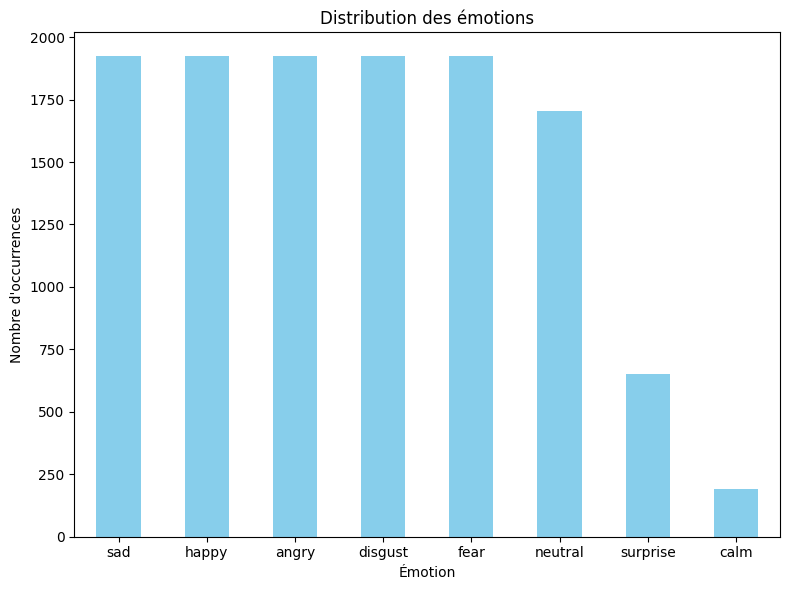

In [33]:
emotion_counts = df['emotion'].value_counts()

# Histogramme de la distribution des émotions dans le jeu de données
plt.figure(figsize=(8, 6))

emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution des émotions')
plt.xlabel('Émotion')
plt.ylabel('Nombre d\'occurrences')

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('distribution_emotions_audio.png')
plt.show()

→ Très peu de données pour *calm* et *surprise*

→ Suppression des données pour ces émotions

In [34]:
df = df[~df['emotion'].isin(['calm', 'surprise'])]
df[['emotion']].value_counts()

emotion
angry      1923
disgust    1923
fear       1923
happy      1923
sad        1923
neutral    1703
dtype: int64

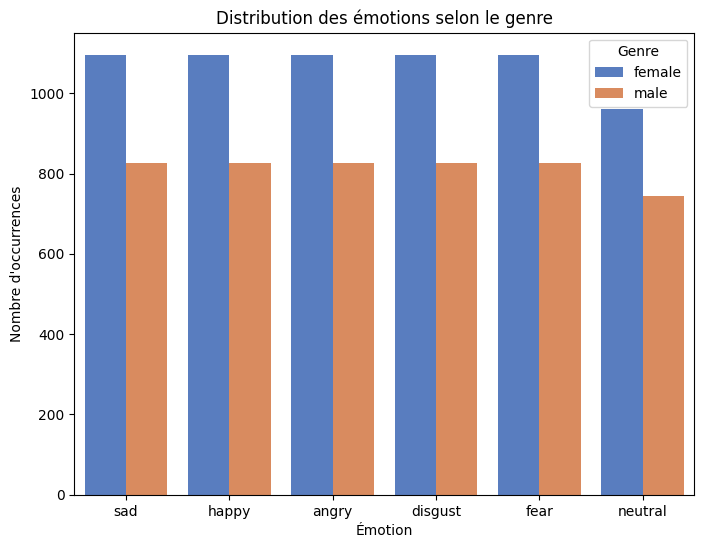

In [35]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='emotion', hue='gender', palette='muted')
plt.title('Distribution des émotions selon le genre')
plt.xlabel('Émotion')
plt.ylabel('Nombre d\'occurrences')
plt.legend(title='Genre')
plt.savefig('distribution_emotions_genre_audio.png')
plt.show()

In [36]:
df.shape

(11318, 3)

# Chargement des fichiers audios

In [37]:
import librosa
from librosa.util import pad_center

from tqdm import tqdm

In [ ]:
# Module nécessaire pour l'extraction des audios
!pip install resampy

In [ ]:
!pip install pydub

In [48]:
from pydub import AudioSegment, effects

In [49]:
def preprocess_audio(path):
    # Chargement de l'audio et récupération du taux d'échantillonage
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)

    # Conversion en tableaux numpy
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    # Supprimer les silences
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    # Tableau rempli de 0 si moins de 180 000 échantillons
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')

    return padded, sr

In [50]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in tqdm(df.itertuples(index=False)):
    try:
        y, sr = preprocess_audio(row.path)

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        # Root Mean Square
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        # Mel-Frequency Cepstral Coefficients
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(row.emotion)
    except:
        print(f"Échec de l'extraction pour : {row.path}")

909it [01:30, 16.04it/s]

Échec de l'extraction pour : ravdess/Actor_20/03-01-06-01-01-02-20.wav


8505it [08:35, 19.22it/s]

Échec de l'extraction pour : savee/ALL/DC_f12.wav


8512it [08:36, 18.26it/s]

Échec de l'extraction pour : savee/ALL/JK_a01.wav
Échec de l'extraction pour : savee/ALL/KL_sa05.wav


8523it [08:36, 19.68it/s]

Échec de l'extraction pour : savee/ALL/DC_sa15.wav
Échec de l'extraction pour : savee/ALL/DC_d08.wav


8528it [08:37, 18.42it/s]

Échec de l'extraction pour : savee/ALL/DC_sa01.wav


8534it [08:37, 17.59it/s]

Échec de l'extraction pour : savee/ALL/KL_sa15.wav


8540it [08:37, 18.35it/s]

Échec de l'extraction pour : savee/ALL/JE_sa11.wav
Échec de l'extraction pour : savee/ALL/JE_n11.wav


8549it [08:38, 18.65it/s]

Échec de l'extraction pour : savee/ALL/DC_d10.wav
Échec de l'extraction pour : savee/ALL/JE_d14.wav


8560it [08:39, 18.09it/s]

Échec de l'extraction pour : savee/ALL/DC_f11.wav


8573it [08:39, 17.14it/s]

Échec de l'extraction pour : savee/ALL/JE_sa01.wav


8578it [08:40, 18.65it/s]

Échec de l'extraction pour : savee/ALL/KL_sa11.wav
Échec de l'extraction pour : savee/ALL/JK_n16.wav


8583it [08:40, 18.45it/s]

Échec de l'extraction pour : savee/ALL/DC_sa13.wav


8588it [08:40, 18.17it/s]

Échec de l'extraction pour : savee/ALL/JK_n27.wav


8601it [08:41, 19.92it/s]

Échec de l'extraction pour : savee/ALL/DC_n11.wav
Échec de l'extraction pour : savee/ALL/JE_f08.wav
Échec de l'extraction pour : savee/ALL/KL_sa14.wav


8604it [08:41, 21.87it/s]

Échec de l'extraction pour : savee/ALL/JE_n15.wav
Échec de l'extraction pour : savee/ALL/JK_sa02.wav
Échec de l'extraction pour : savee/ALL/JK_d10.wav


8618it [08:42, 12.06it/s]

Échec de l'extraction pour : savee/ALL/JE_a15.wav
Échec de l'extraction pour : savee/ALL/KL_h15.wav


8622it [08:42, 13.25it/s]

Échec de l'extraction pour : savee/ALL/JK_n15.wav
Échec de l'extraction pour : savee/ALL/DC_n28.wav


8626it [08:43, 12.04it/s]

Échec de l'extraction pour : savee/ALL/DC_sa10.wav


8630it [08:43, 11.53it/s]

Échec de l'extraction pour : savee/ALL/JE_sa08.wav


8634it [08:44, 11.31it/s]

Échec de l'extraction pour : savee/ALL/DC_d04.wav


8640it [08:44, 10.89it/s]

Échec de l'extraction pour : savee/ALL/DC_d01.wav


8642it [08:44, 12.48it/s]

Échec de l'extraction pour : savee/ALL/JK_sa15.wav


8646it [08:45, 11.99it/s]

Échec de l'extraction pour : savee/ALL/DC_n15.wav


8658it [08:45, 15.74it/s]

Échec de l'extraction pour : savee/ALL/JE_sa05.wav
Échec de l'extraction pour : savee/ALL/DC_n14.wav


8661it [08:46, 19.03it/s]

Échec de l'extraction pour : savee/ALL/JE_d01.wav
Échec de l'extraction pour : savee/ALL/JE_f09.wav
Échec de l'extraction pour : savee/ALL/JK_n11.wav


8670it [08:46, 18.77it/s]

Échec de l'extraction pour : savee/ALL/JE_d13.wav


8675it [08:46, 19.90it/s]

Échec de l'extraction pour : savee/ALL/JE_h15.wav
Échec de l'extraction pour : savee/ALL/JE_h12.wav
Échec de l'extraction pour : savee/ALL/DC_h05.wav


8681it [08:47, 20.54it/s]

Échec de l'extraction pour : savee/ALL/KL_h11.wav
Échec de l'extraction pour : savee/ALL/DC_d09.wav


8691it [08:47, 18.35it/s]

Échec de l'extraction pour : savee/ALL/JK_sa13.wav


8697it [08:47, 18.09it/s]

Échec de l'extraction pour : savee/ALL/JK_sa11.wav
Échec de l'extraction pour : savee/ALL/JK_d15.wav
Échec de l'extraction pour : savee/ALL/JK_sa10.wav


8705it [08:48, 18.94it/s]

Échec de l'extraction pour : savee/ALL/DC_sa04.wav


8721it [08:49, 19.56it/s]

Échec de l'extraction pour : savee/ALL/JE_n07.wav
Échec de l'extraction pour : savee/ALL/JE_n28.wav
Échec de l'extraction pour : savee/ALL/JE_sa15.wav


8725it [08:49, 22.38it/s]

Échec de l'extraction pour : savee/ALL/JK_f15.wav
Échec de l'extraction pour : savee/ALL/JE_f07.wav
Échec de l'extraction pour : savee/ALL/JE_f11.wav
Échec de l'extraction pour : savee/ALL/JK_f08.wav


8731it [08:49, 22.09it/s]

Échec de l'extraction pour : savee/ALL/JE_f15.wav
Échec de l'extraction pour : savee/ALL/DC_sa05.wav
Échec de l'extraction pour : savee/ALL/JE_sa13.wav


8744it [08:50, 19.31it/s]

Échec de l'extraction pour : savee/ALL/KL_sa04.wav
Échec de l'extraction pour : savee/ALL/KL_sa12.wav


8749it [08:50, 19.46it/s]

Échec de l'extraction pour : savee/ALL/JK_sa01.wav
Échec de l'extraction pour : savee/ALL/KL_d15.wav


8753it [08:50, 16.83it/s]

Échec de l'extraction pour : savee/ALL/JE_n27.wav
Échec de l'extraction pour : savee/ALL/JE_h01.wav
Échec de l'extraction pour : savee/ALL/DC_h12.wav


8763it [08:51, 15.09it/s]

Échec de l'extraction pour : savee/ALL/JK_sa12.wav


8769it [08:52, 12.06it/s]

Échec de l'extraction pour : savee/ALL/KL_n14.wav
Échec de l'extraction pour : savee/ALL/DC_f15.wav


8779it [08:52, 19.97it/s]

Échec de l'extraction pour : savee/ALL/DC_h15.wav
Échec de l'extraction pour : savee/ALL/KL_n11.wav
Échec de l'extraction pour : savee/ALL/DC_sa06.wav
Échec de l'extraction pour : savee/ALL/DC_sa14.wav


8782it [08:52, 19.69it/s]

Échec de l'extraction pour : savee/ALL/DC_n30.wav


8788it [08:53, 18.79it/s]

Échec de l'extraction pour : savee/ALL/JK_a14.wav
Échec de l'extraction pour : savee/ALL/JK_n30.wav


8794it [08:53, 20.89it/s]

Échec de l'extraction pour : savee/ALL/DC_d14.wav
Échec de l'extraction pour : savee/ALL/DC_h14.wav
Échec de l'extraction pour : savee/ALL/DC_h11.wav


8800it [08:53, 20.34it/s]

Échec de l'extraction pour : savee/ALL/JK_h11.wav
Échec de l'extraction pour : savee/ALL/JK_n01.wav

8803it [08:53, 21.54it/s]


Échec de l'extraction pour : savee/ALL/DC_sa12.wav
Échec de l'extraction pour : savee/ALL/DC_sa11.wav


8810it [08:54, 22.53it/s]

Échec de l'extraction pour : savee/ALL/DC_a14.wav
Échec de l'extraction pour : savee/ALL/JK_n14.wav
Échec de l'extraction pour : savee/ALL/JE_a14.wav


8816it [08:54, 20.05it/s]

Échec de l'extraction pour : savee/ALL/JK_sa14.wav


8822it [08:54, 21.20it/s]

Échec de l'extraction pour : savee/ALL/JK_sa04.wav
Échec de l'extraction pour : savee/ALL/DC_n06.wav
Échec de l'extraction pour : savee/ALL/JK_f12.wav


8825it [08:54, 20.13it/s]

Échec de l'extraction pour : savee/ALL/DC_d13.wav


8828it [08:55, 18.84it/s]

Échec de l'extraction pour : savee/ALL/JK_f07.wav
Échec de l'extraction pour : savee/ALL/DC_f14.wav


8836it [08:55, 17.67it/s]

Échec de l'extraction pour : savee/ALL/DC_a13.wav


8848it [08:56, 10.74it/s]

Échec de l'extraction pour : savee/ALL/JE_sa10.wav


8853it [08:57, 12.52it/s]

Échec de l'extraction pour : savee/ALL/JK_d14.wav
Échec de l'extraction pour : savee/ALL/JE_h11.wav
Échec de l'extraction pour : savee/ALL/JK_sa05.wav


8856it [08:57, 13.78it/s]

Échec de l'extraction pour : savee/ALL/KL_f11.wav
Échec de l'extraction pour : savee/ALL/KL_sa13.wav
Échec de l'extraction pour : savee/ALL/JK_a13.wav


8861it [08:57, 14.63it/s]

Échec de l'extraction pour : savee/ALL/JE_n14.wav


8867it [08:58, 12.19it/s]

Échec de l'extraction pour : savee/ALL/JE_sa12.wav


8872it [08:58, 11.88it/s]

Échec de l'extraction pour : savee/ALL/DC_n27.wav
Échec de l'extraction pour : savee/ALL/JK_d01.wav
Échec de l'extraction pour : savee/ALL/JE_d09.wav


8877it [08:58, 14.47it/s]

Échec de l'extraction pour : savee/ALL/JE_d08.wav
Échec de l'extraction pour : savee/ALL/JE_sa06.wav


8881it [08:59, 15.91it/s]

Échec de l'extraction pour : savee/ALL/KL_sa10.wav
Échec de l'extraction pour : savee/ALL/DC_d15.wav
Échec de l'extraction pour : savee/ALL/JK_h12.wav


8888it [08:59, 15.85it/s]

Échec de l'extraction pour : savee/ALL/JE_f12.wav


8897it [09:00, 16.69it/s]

Échec de l'extraction pour : savee/ALL/JK_d13.wav


8906it [09:00, 17.81it/s]

Échec de l'extraction pour : savee/ALL/DC_n10.wav


8914it [09:01, 17.47it/s]

Échec de l'extraction pour : savee/ALL/JE_sa04.wav
Échec de l'extraction pour : savee/ALL/JE_d15.wav
Échec de l'extraction pour : savee/ALL/JE_n05.wav


8920it [09:01, 17.86it/s]

Échec de l'extraction pour : savee/ALL/JE_sa14.wav


11318it [11:13, 16.81it/s]


In [51]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

In [52]:
X. shape

(11199, 352, 15)

In [53]:
y = np.array(emotion_list)

# Traitement des données

In [54]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [55]:
NB_CLASSES = 6

# Encodage des labels en entiers
le = LabelEncoder()
le.fit(y)
labels = le.transform(y)

# Encodage One-Hot des labels
labels = to_categorical(labels, num_classes=6)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=42)

# Création du modèle

In [57]:
from keras import models
from keras.layers import LSTM, Dense

from keras.callbacks import ModelCheckpoint

In [77]:
# Instauration d'un checkpoint pour la meilleure valeur de val_loss
checkpoint = ModelCheckpoint(
    filepath='ck_model_audio.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min' # minimisation de la loss sur l'ensemble de validation
)

In [78]:
model = models.Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1:3])))
model.add(LSTM(64))

model.add(Dense(NB_CLASSES, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 352, 64)           20480     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 53894 (210.52 KB)
Trainable params: 53894 (210.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [80]:
history = model.fit(X_train, y_train, batch_size=32, epochs=300, validation_split=0.1, callbacks=[checkpoint])

Epoch 1/300
283/284 [============================>.] - ETA: 0s - loss: 1.6188 - accuracy: 0.3096
Epoch 1: val_loss improved from inf to 1.56039, saving model to ck_model_audio.keras
284/284 [==============================] - 11s 30ms/step - loss: 1.6182 - accuracy: 0.3101 - val_loss: 1.5604 - val_accuracy: 0.3621
Epoch 2/300
282/284 [============================>.] - ETA: 0s - loss: 1.5780 - accuracy: 0.3299
Epoch 2: val_loss improved from 1.56039 to 1.53061, saving model to ck_model_audio.keras
284/284 [==============================] - 7s 26ms/step - loss: 1.5774 - accuracy: 0.3303 - val_loss: 1.5306 - val_accuracy: 0.3472
Epoch 3/300
283/284 [============================>.] - ETA: 0s - loss: 1.5545 - accuracy: 0.3351
Epoch 3: val_loss did not improve from 1.53061
284/284 [==============================] - 8s 28ms/step - loss: 1.5544 - accuracy: 0.3355 - val_loss: 1.5880 - val_accuracy: 0.3155
Epoch 4/300
282/284 [============================>.] - ETA: 0s - loss: 1.5336 - accuracy: 0

# Résultats et interprétations

In [81]:
from sklearn.metrics import confusion_matrix

In [82]:
# Accuracy et loss du train set et validation set pendant l'entraînement
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(history.epoch) + 1)

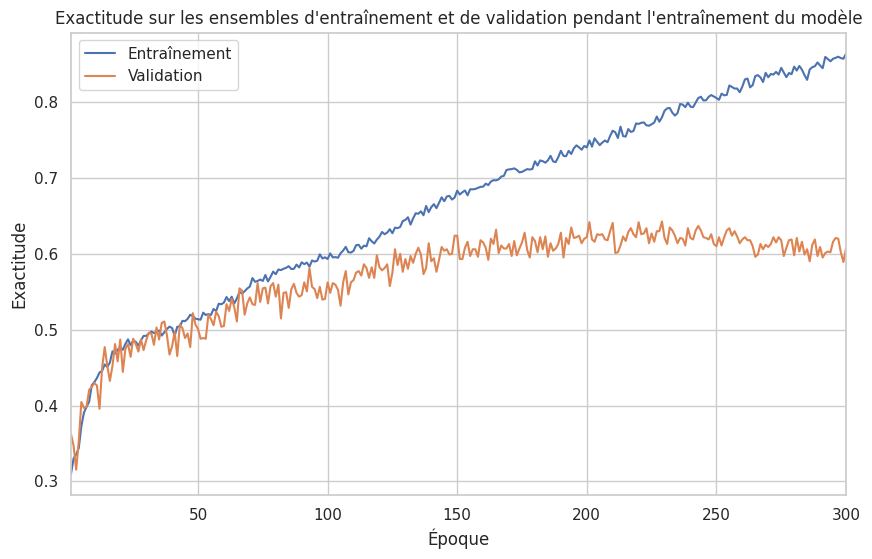

In [91]:
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Entraînement')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Exactitude sur les ensembles d\'entraînement et de validation pendant l\'entraînement du modèle')
plt.xlabel('Époque')
plt.ylabel('Exactitude')
plt.legend()
plt.xlim(1, 300)
plt.savefig('accuracy_modele_audio.png')
plt.show()

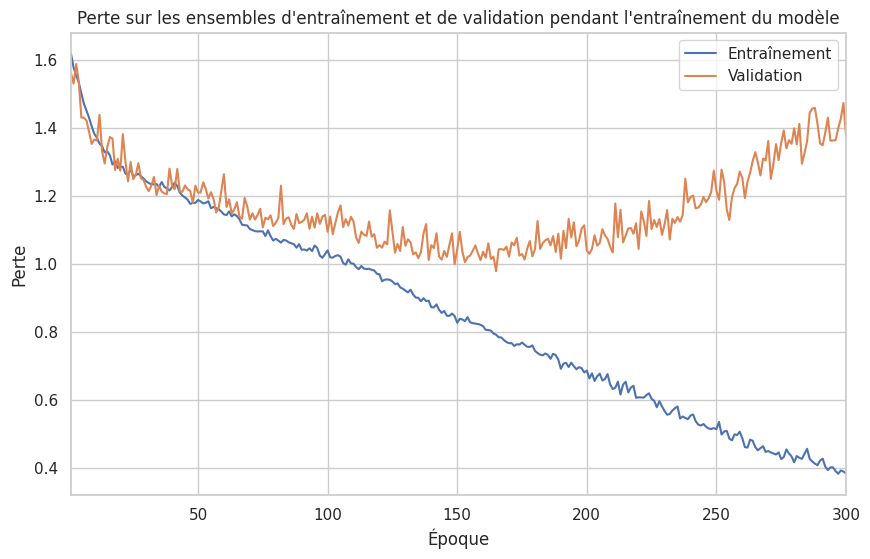

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Entraînement')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Perte sur les ensembles d\'entraînement et de validation pendant l\'entraînement du modèle')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.xlim(1, 300)
plt.savefig('loss_modele_audio.png')
plt.show()

In [85]:
model.save('audio_model.keras')

In [86]:
# Évaluation du modèle
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32)

print("Perte avec l'ensemble de test : ", test_loss)
print("Exactitude avec l'ensemble de test : ", test_acc)

35/35 [==============================] - 0s 12ms/step - loss: 1.4616 - accuracy: 0.6018
Perte avec l'ensemble de test :  1.461611032485962
Exactitude avec l'ensemble de test :  0.6017857193946838


In [87]:
# Prédictions faites par le modèle sur l'ensemble de test
predictions = model.predict(X_test)
# Récupération des indices de la valeur maximale dans le vecteur de la prédiction du modèle
predicted_classes = np.argmax(predictions, axis=1)

# Nom des classes pour légender les lignes/colonnes de la matrice
classes_name = set(le.inverse_transform(predicted_classes))

35/35 [==============================] - 1s 10ms/step


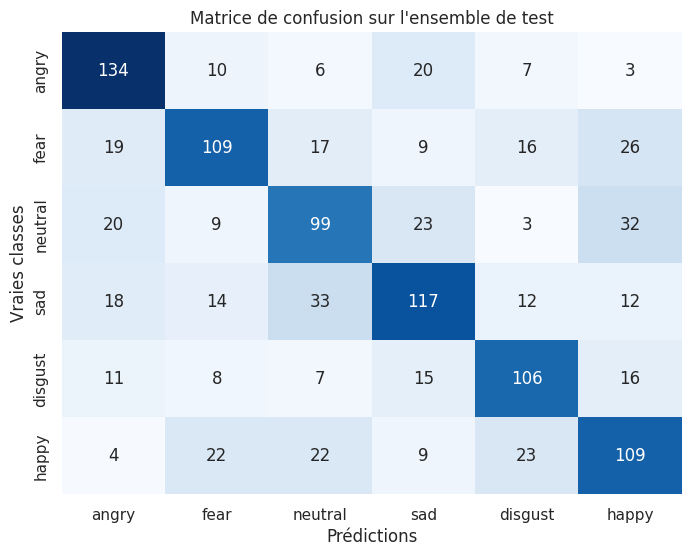

In [88]:
# Matrice de confusion
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes_name, yticklabels=classes_name)
plt.xlabel('Prédictions')
plt.ylabel('Vraies classes')
plt.title('Matrice de confusion sur l\'ensemble de test')

plt.savefig('matrice_confusion_audio.png')
plt.show()

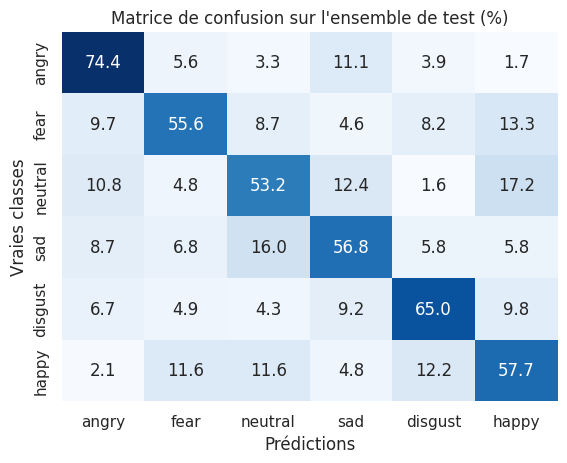

In [89]:
# Matrice de confusion en pourcentage
conf_matrix_sum = np.sum(conf_matrix, axis=1, keepdims=True)
conf_matrix_percent = conf_matrix / conf_matrix_sum.astype(float) * 100

sns.heatmap(conf_matrix_percent, annot=True, fmt='.1f', cmap='Blues', cbar=False,
            xticklabels=classes_name, yticklabels=classes_name)

plt.title('Matrice de confusion sur l\'ensemble de test (%)')
plt.xlabel('Prédictions')
plt.ylabel('Vraies classes')

plt.savefig('matrice_confusion_pourcent_audio.png')
plt.show()